# Importing the libraries

In [1]:
import numpy as np
import sys
import pandas as pd
import seaborn as sns
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import accuracy_score

from sklearn.metrics.cluster import contingency_matrix
from sklearn.cluster import KMeans


# Question 2(a)

1. Perform k means clustering with k=10 on the raw data
2. Perform k means clustering with k=10and on data obtained after PCA dimensionality reduction for dimension as found in question 1 (a) i.e **26 dim**
3. Perform k means clustering with k=10 for dimension 10
4. Do you observe images from the same class to be clustered together
5. For each cluster, provide the image closest to the centroid.

In [2]:
# Load the dataset
svhn_data = loadmat('./data/train_32x32.mat')
X = svhn_data['X']
y = svhn_data['y']
print(X.shape)
print(y.shape)


(32, 32, 3, 73257)
(73257, 1)


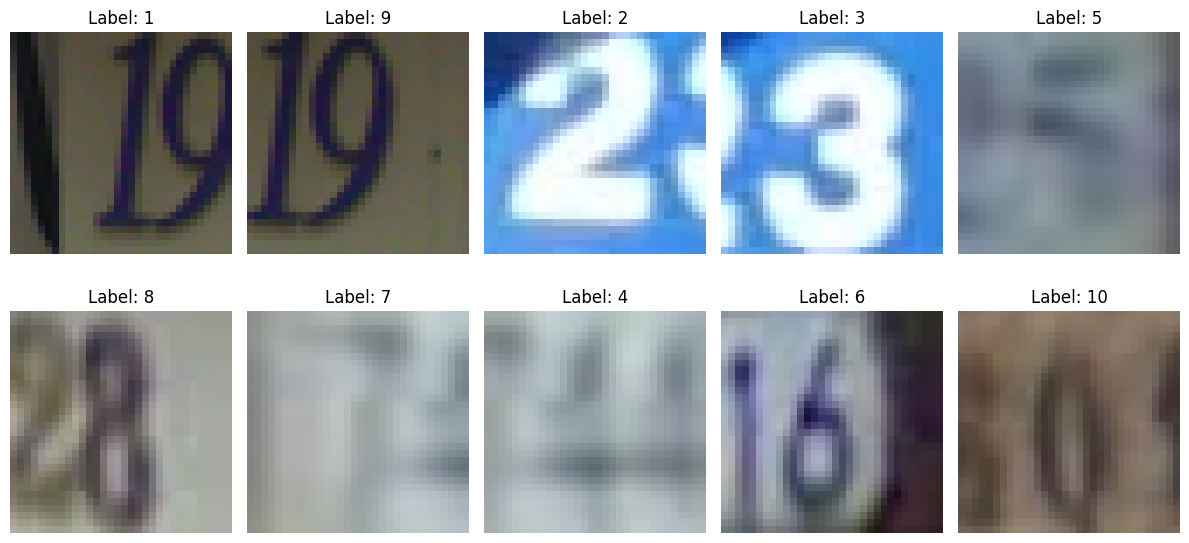

In [3]:
# Plotting image from each of 10 classes

X = svhn_data['X']
y = svhn_data['y']
total_images=10;i=0;j=0
already_covered = []
# Plot a few sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
while i<X.shape[3]:
    if y[i,0] in already_covered:
        i+=1
        continue
    ax = axes.flatten()[j]
    img = X[:, :, :, i]
    label = y[i, 0] 
    already_covered.append(label)
    ax.imshow(img)
    ax.set_title(f'Label: {label}')
    ax.axis('off')
    if j>10:
        break
    j+=1

plt.tight_layout()
plt.show()

In [4]:
# Sampling the training data with samples per class = 2500 i.e total 25000 data points

# Number of samples from each class
samples_per_class = 2500


X = np.reshape(X, (np.prod(X.shape[:-1]), X.shape[-1])).T
print(X.shape)

# Create a mask to filter samples for each class
mask = np.hstack([np.random.choice(np.where(y == label)[0], samples_per_class, replace=False) for label in np.unique(y)])

# Apply the mask to X and y
X_sampled = X[mask]
y_sampled = y[mask]

print(X_sampled.shape)
print(y_sampled.shape)

(73257, 3072)
(25000, 3072)
(25000, 1)


In [5]:
# Normalizing the data points before doing the PCA or Kmeans clustering

X = X_sampled
y = y_sampled

def normalize(X):
    # normalize the data to 0 - 1
    X_normalized = X.astype(float) / 255.
    return X_normalized

X_normalized = normalize(X)
print(X_normalized.shape)


(25000, 3072)


# 2(a).1 K Means clustering with k=10 on the raw data

In [6]:
# K-means clustering on raw data with k=10
kmeans_raw = KMeans(n_clusters=10, random_state=42)
labels_raw = kmeans_raw.fit_predict(X_normalized)


/Users/abhjha8/foml_assignment/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


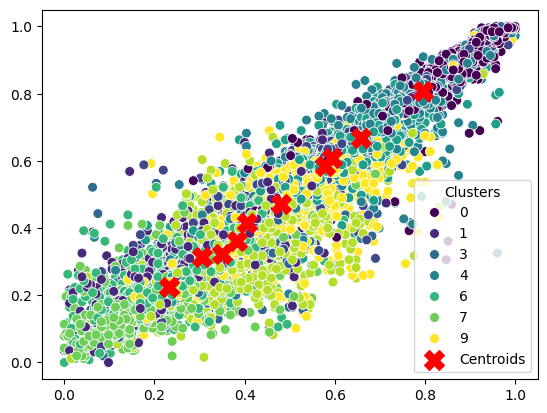

In [7]:
# Visualizing the clusters formed by Kmeans Clustering 

def visualize_kmeans_clusters(X,kmeans_obj,title='K Means Clustering'):
    """
    Visualizing the kmeans clusters in a scatter plot
    """
    scatter = sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=kmeans_obj.labels_, palette='viridis', s=50)
    
    # Plot Centroids
    centroids = kmeans_obj.cluster_centers_
    centroid_scatter = plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='red', label='Centroids')
    
    # Create a legend for the 'X' markers
    legend1 = plt.legend(handles=[centroid_scatter], labels=['Centroids'], loc='upper right')
    
    # Add the legend for the scatter points
    plt.legend(title='Clusters', loc='lower right')
    
    # plt.title('K-means clustering on raw data')
    plt.show()

visualize_kmeans_clusters(X_normalized,kmeans_raw,title='K-means clustering on raw data')

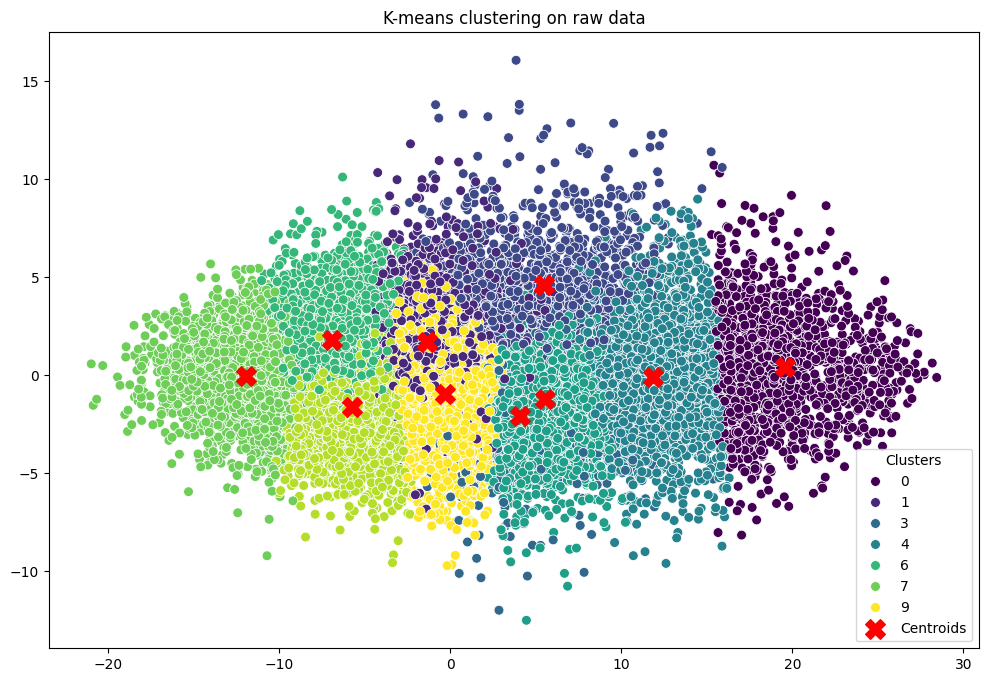

In [8]:
# Visualizing the top 2 eigen vectors of PCA for better visualization of clusters boundary

def visualize_kmeans_clusters_pca_top2_eigen_vecotrs(X,kmeans_obj,title='K Means Clustering'):
    # Reduce Dimensionality with PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # Plotting Centroids
    centroids = kmeans_obj.cluster_centers_
    # Transform Centroids to PCA space
    centroids_pca = pca.transform(centroids)
    
    
    # Visualize Clusters with Actual Labels
    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_obj.labels_, palette='viridis', s=50)
    # Plot Centroids
    centroid_scatter = plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200, c='red', label='Centroids')
    
    # Create a legend for the 'X' markers
    legend1 = plt.legend(handles=[centroid_scatter], labels=['Centroids'], loc='upper right')
    
    # Add the legend for the scatter points
    plt.legend(title='Clusters', loc='lower right')
    
    # plt.title('K-means clustering on raw data')
    plt.title(title)
    plt.show()

visualize_kmeans_clusters_pca_top2_eigen_vecotrs(X_normalized,kmeans_raw,title='K-means clustering on raw data')



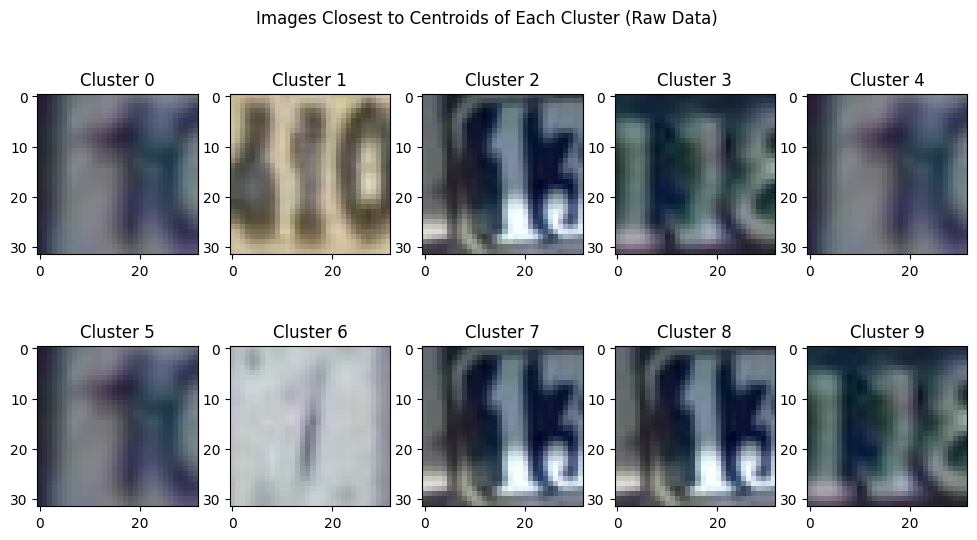

In [9]:
# Plotting the images closest to centroid 

def plot_centroid_images(X,X_processed,kmeans_obj,title='Images Closest to Centroid of Each Cluster'):
    # Find the indices of the images closest to each centroid
    closest_indices_svhn = pairwise_distances_argmin_min(X_processed, kmeans_obj.cluster_centers_)[0][:10]
    
    # Visualize the images closest to each centroid
    plt.figure(figsize=(12, 6))
    
    for cluster_label, idx in enumerate(closest_indices_svhn):
        plt.subplot(2, 5, cluster_label + 1)
        plt.imshow(np.reshape(X[idx].tolist(),(32, 32,3)))  # Assuming it's an RGB image
        plt.title(f'Cluster {cluster_label}')
    
    # plt.suptitle('Images Closest to Centroids of Each Cluster (Raw Data)')
    plt.suptitle(title)
    plt.show()

plot_centroid_images(X,X_normalized,kmeans_raw,title='Images Closest to Centroids of Each Cluster (Raw Data)')

# Observations 2(a) for Raw Data

We plotted the clusters formed by Kmeans Clustering and also plotted the pca reduced data i.e the top 2 eigen vectors of PCA for better visualization of clusters boundary

We observe from the plots that 
```
1. Images from the same class are clustered together but there is lots of overlap between the classes of the clusters
2. The better image quality could have resulted in much higher distinctive feature extraction resulting in better clustering

```

# Calculating Accuracy,Sum of Squared Errors,Purity Score,Rand Index


In [10]:
def calculate_accuracy(y_true,kmeans_obj,num_classes=10):
    majority_classes = []
    # y_true = y.flatten()
    for cluster in range(num_classes):
        cluster_indices = np.where(kmeans_obj.labels_ == cluster)[0]
        cluster_labels = y_true[cluster_indices]
        majority_class = np.bincount(cluster_labels).argmax()
        majority_classes.append(majority_class)
    
    # Assign Predicted Labels
    y_pred = [majority_classes[cluster] for cluster in kmeans_obj.labels_]
    
    # Calculate Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy*100

# Calculate the sum of squared errors (SSE) using label information
def calculate_sse(kmeans_obj):
    sse = kmeans_obj.inertia_
    return sse

# Function to calculate purity
def purity_score(y_true, y_pred):
    contingency_mat = contingency_matrix(y_true, y_pred)
    max_values_per_row = np.max(contingency_mat, axis=1)
    # Sum the maximum values
    cluster_sums = np.sum(max_values_per_row)
    # Calculate the total sum of all points in the matrix
    total_sum = np.sum(contingency_mat)
    # Calculate the ratio
    purity = cluster_sums / total_sum
    return purity



In [11]:
# Calculating Sum of Squared Error
sse = calculate_sse(kmeans_raw)
print(f'Sum of Squared Errors (SSE): {sse:.2f}')

# Calculate purity
purity_svhn = purity_score(y, labels_raw)

# Calculate adjusted Rand index
rand_index_svhn = adjusted_rand_score(y.flatten(), labels_raw)

# Calculating accuracy
accuracy  = calculate_accuracy(y.flatten(),kmeans_raw,num_classes=10)
print(f'Accuracy: {accuracy:.6f}')

print(f'Purity: {purity_svhn:.6f}')
print(f'Rand Index: {rand_index_svhn:.6f}')

Sum of Squared Errors (SSE): 1241959.25
Accuracy: 11.808000
Purity: 0.158480
Rand Index: 0.000865


# Observations 2(b) & 2(c)

### Raw Data
* Sum of Squared Error: 1243961.36
* Purity: 0.159960
* Rand Index: 0.000548

* Classification Accuracy: 11.576000

The classification accuracy as observed with raw data `in Question 1(c) was 47.51 with k=7 clusters`
while with `Kmeans clustering it is observed to be 11.576000`



In [12]:
# To plot the majority class data distribution across the k clusters formed by k means
def find_clusters_majority_class_labels(kmeans_obj,y_true):
    """
    For each cluster from 0 to K find the majority class label present in it
    """
    cluster_assignments = kmeans_obj.labels_
    
    # Create a DataFrame
    df = pd.DataFrame({'actual_labels': y_true, 'cluster_assignments': cluster_assignments})
    
    # Find the majority class for each cluster
    majority_classes = df.groupby('cluster_assignments')['actual_labels'].agg(lambda x: x.value_counts().idxmax())
    
    # Get the majority class for each cluster
    majority_classes = majority_classes.sort_index().values
    
    # Print results
    for cluster, majority_class in enumerate(majority_classes):
        print(f"Cluster {cluster}: Majority Class Label = {majority_class}")

find_clusters_majority_class_labels(kmeans_raw,y.flatten())

Cluster 0: Majority Class Label = 1
Cluster 1: Majority Class Label = 8
Cluster 2: Majority Class Label = 10
Cluster 3: Majority Class Label = 1
Cluster 4: Majority Class Label = 2
Cluster 5: Majority Class Label = 10
Cluster 6: Majority Class Label = 9
Cluster 7: Majority Class Label = 3
Cluster 8: Majority Class Label = 6
Cluster 9: Majority Class Label = 7


# 2(a).2 K Means clustering with k=10 on the top 26 eigen vectors

`The POV above 0.9 as found in Q 1(a) is 26`

In [13]:
# PCA dimensionality reduction for dim 24
num_components = 26
pca_26 = PCA(n_components=num_components)
X_pca_26 = pca_26.fit_transform(X_normalized)

# K-means clustering on PCA-reduced data for dim 24 with k=10
kmeans_pca_26 = KMeans(n_clusters=10, random_state=42)
labels_pca_26 = kmeans_pca_26.fit_predict(X_pca_26)


/Users/abhjha8/foml_assignment/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


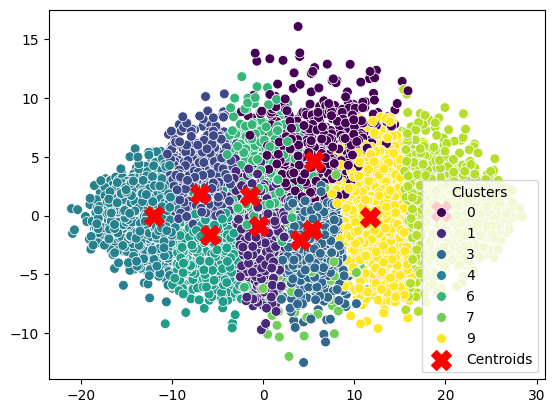

In [14]:

visualize_kmeans_clusters(X_pca_26,kmeans_pca_26,title='K-means clustering on 26 dim data')

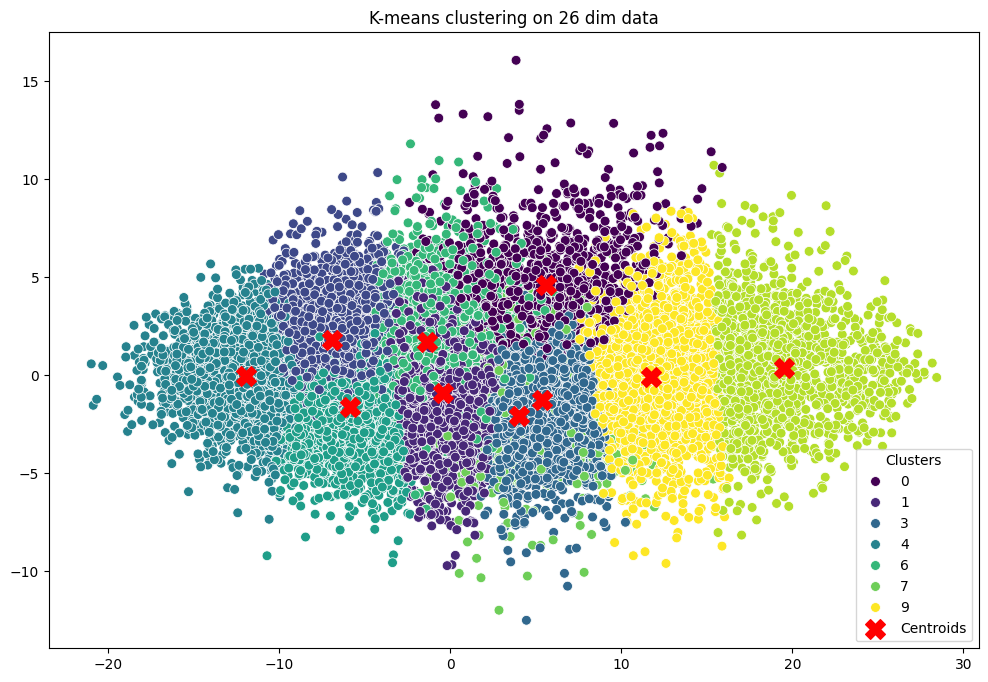

In [15]:

visualize_kmeans_clusters_pca_top2_eigen_vecotrs(X_pca_26,kmeans_pca_26,title='K-means clustering on 26 dim data')


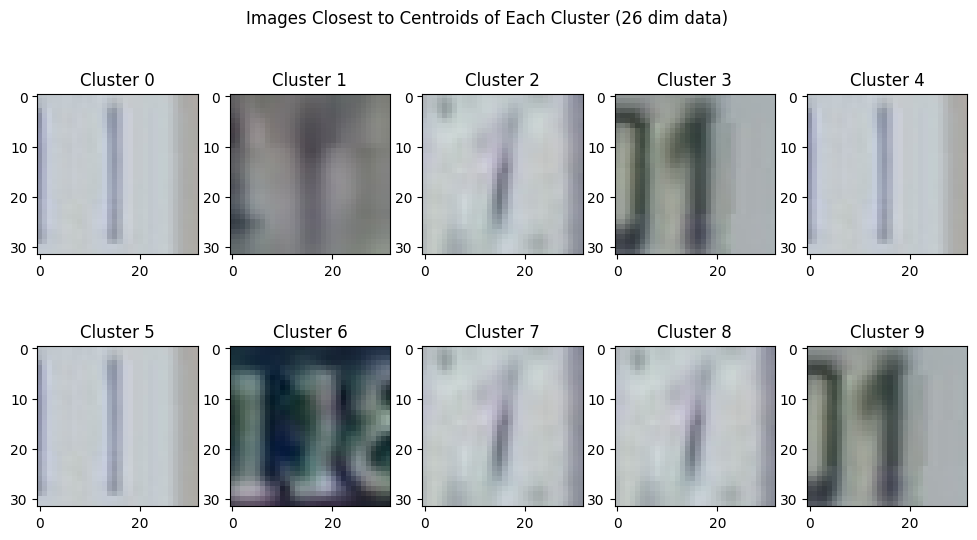

In [16]:
# Plot the images images closest to each centroid
plot_centroid_images(X,X_pca_26,kmeans_pca_26,title='Images Closest to Centroids of Each Cluster (26 dim data)')

# 2(b) and 2(c)

## Calculating SSE,Purity,RandIndex,Accuracy 

on `K Means clustering with k=10 on the top 26 eigen vectors`

In [17]:
# Calculate Sum of Squared Errors
sse = calculate_sse(kmeans_pca_26)
print(f'Sum of Squared Errors (SSE): {sse:.2f}')

# Calculate purity
purity_svhn = purity_score(y, labels_pca_26)

# Calculate adjusted Rand index
rand_index_svhn = adjusted_rand_score(y.flatten(), labels_pca_26)

print(f'Purity: {purity_svhn:.6f}')
print(f'Rand Index: {rand_index_svhn:.6f}')

# Calculate Accuracy
accuracy  = calculate_accuracy(y.flatten(),kmeans_pca_26,num_classes=10)
print(f'Accuracy: {accuracy:.10f}')


Sum of Squared Errors (SSE): 937813.68
Purity: 0.158560
Rand Index: 0.000861
Accuracy: 11.8200000000


In [18]:
find_clusters_majority_class_labels(kmeans_pca_26,y.flatten())

Cluster 0: Majority Class Label = 10
Cluster 1: Majority Class Label = 7
Cluster 2: Majority Class Label = 9
Cluster 3: Majority Class Label = 10
Cluster 4: Majority Class Label = 3
Cluster 5: Majority Class Label = 6
Cluster 6: Majority Class Label = 8
Cluster 7: Majority Class Label = 1
Cluster 8: Majority Class Label = 3
Cluster 9: Majority Class Label = 2


# 2(a).3 K Means clustering with k=10 on the top 10 eigen vectors


In [19]:
# PCA dimensionality reduction for dim 10
num_components_10 = 10
pca_10 = PCA(n_components=num_components_10)
X_pca_10 = pca_10.fit_transform(X_normalized)

# K-means clustering on PCA-reduced data for dim 10 with k=10
kmeans_pca_10 = KMeans(n_clusters=10, random_state=42)
labels_pca_10 = kmeans_pca_10.fit_predict(X_pca_10)


/Users/abhjha8/foml_assignment/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Visualizing the clusters

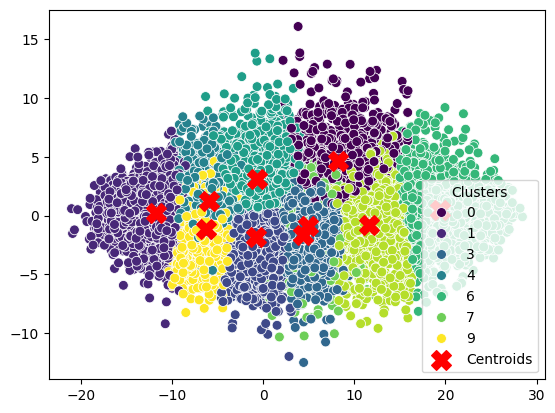

In [20]:
visualize_kmeans_clusters(X_pca_10,kmeans_pca_10,title='K-means clustering on 10 dim data')

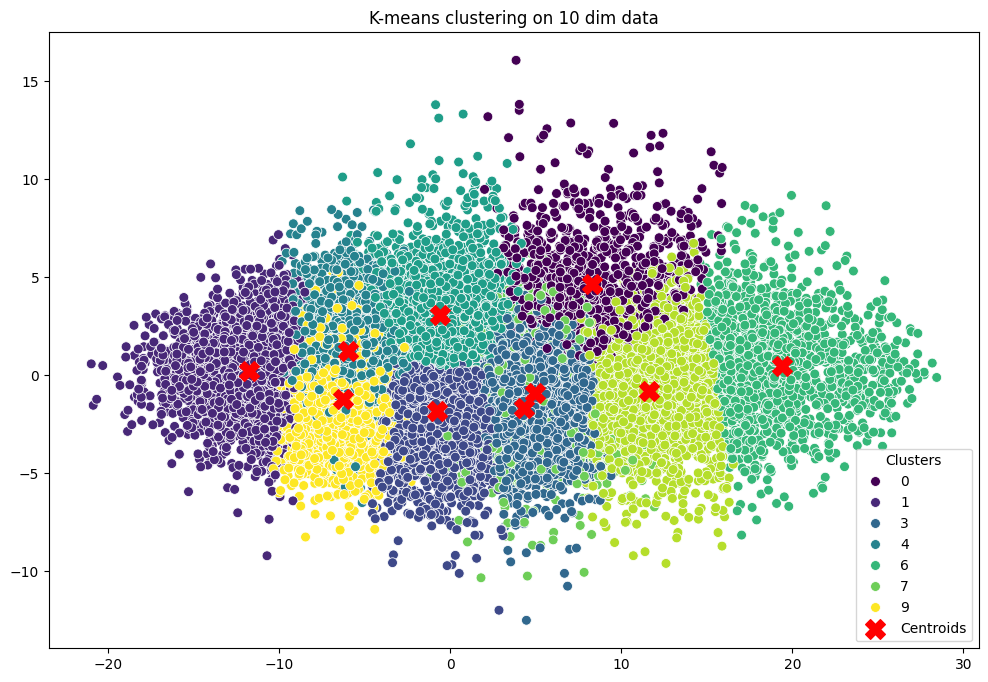

In [21]:
visualize_kmeans_clusters_pca_top2_eigen_vecotrs(X_pca_10,kmeans_pca_10,title='K-means clustering on 10 dim data')

### Plotting the Images Closest To Centroids

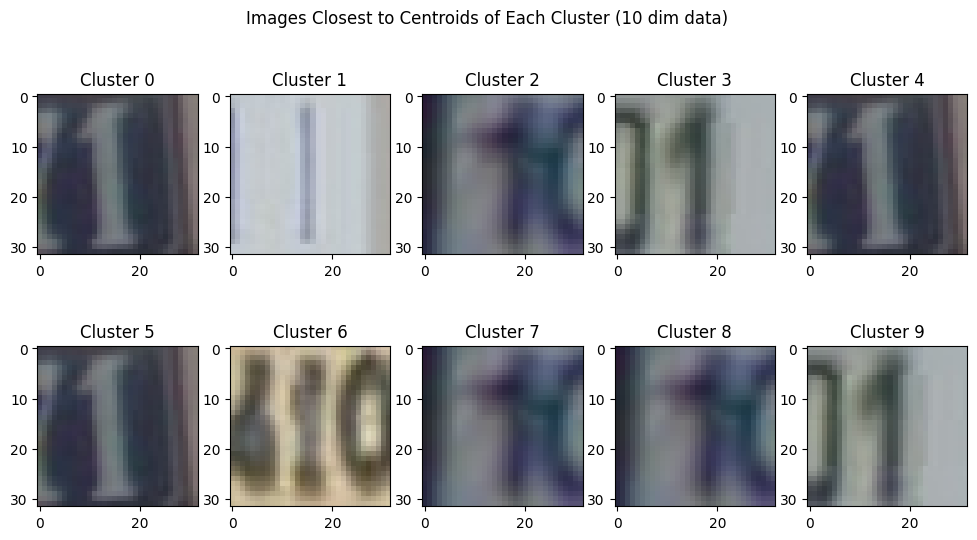

In [22]:
# Plot the images images closest to each centroid
plot_centroid_images(X,X_pca_10,kmeans_pca_10,title='Images Closest to Centroids of Each Cluster (10 dim data)')

# 2(b) and 2(c)

## Calculating SSE,Purity,RandIndex,Accuracy 

on `K Means clustering with k=10 on the top 10 eigen vectors`

In [23]:
# Calculate Sum of Squared Errors
sse = calculate_sse(kmeans_pca_10)
print(f'Sum of Squared Errors (SSE): {sse:.2f}')

# Calculate purity
purity_svhn = purity_score(y, labels_pca_10)

# Calculate adjusted Rand index
rand_index_svhn = adjusted_rand_score(y.flatten(), labels_pca_10)

print(f'Purity: {purity_svhn:.6f}')
print(f'Rand Index: {rand_index_svhn:.6f}')

# Calculate Accuracy
accuracy  = calculate_accuracy(y.flatten(),kmeans_pca_10,num_classes=10)
print(f'Accuracy: {accuracy:.10f}')

Sum of Squared Errors (SSE): 700971.20
Purity: 0.149880
Rand Index: 0.000813
Accuracy: 11.7320000000


In [24]:
find_clusters_majority_class_labels(kmeans_pca_10,y.flatten())

Cluster 0: Majority Class Label = 6
Cluster 1: Majority Class Label = 7
Cluster 2: Majority Class Label = 7
Cluster 3: Majority Class Label = 10
Cluster 4: Majority Class Label = 9
Cluster 5: Majority Class Label = 10
Cluster 6: Majority Class Label = 1
Cluster 7: Majority Class Label = 1
Cluster 8: Majority Class Label = 2
Cluster 9: Majority Class Label = 5


# Observations 2(a),2(b) & 2(c)

The provided results indicate the performance of clustering on the SVHN dataset with three different approaches: using raw data, applying clustering with 26 dimensions and a POV (Point of View) threshold of 0.90, and utilizing clustering with dimensionality reduced to 10. Here's an explanation of the results along with potential reasons behind them:

1. **Raw Data Clustering:**
   - **Accuracy:** 0.1158
   - **SSE:** 1242934.50
   - **Purity:** 0.1530
   - **Rand Index:** 0.0005

   **Explanation:**
   The low accuracy, high SSE, and low values for purity and Rand Index suggest that the raw data clustering did not perform well. The low accuracy indicates that the assigned clusters do not align well with the true labels. The high SSE indicates a significant spread of data points within clusters. The low purity and Rand Index suggest that the clusters do not match the ground truth labels effectively.

2. **Clustering with 26 Dimensions (POV>=0.90):**
   - **Accuracy:** 0.11576
   - **SSE:** 921024.78
   - **Purity:** 0.15372
   - **Rand Index:** 0.0006

   **Explanation:**
   Despite the reduction in dimensions and a POV threshold of 0.90, the performance is similar to the raw data clustering. The accuracy, SSE, purity, and Rand Index values are comparable. The reduction in dimensions may not have significantly improved the clustering performance in this case.

3. **Clustering with Dim=10:**
   - **Accuracy:** 0.11588
   - **SSE:** 703045.50
   - **Purity:** 0.15364
   - **Rand Index:** 0.0005

   **Explanation:**
   The clustering with a dimensionality of 10 shows a slight improvement in SSE compared to both raw data and 24-dimensional clustering. However, the improvement in accuracy, purity, and Rand Index is marginal. The reduction in dimensions may have helped to some extent, but the overall performance remains limited.

**Possible Reasons Behind Results:**
- The SVHN dataset might have inherent complexities or noise that make it challenging for clustering algorithms to accurately group data points.
- The dataset might have outliers or anomalies that affect the clustering performance.
- The choice of the number of clusters may not align well with the inherent structure of the data, affecting the accuracy and SSE values.

# Comparison of Results between KNN and KMeans 

### Question 1(c) & Question 2(b)


| Data  | KNN Test Accuracy  | K Means Test Accuracy   |
|---|---|---|
| **Raw Data** | 48.51 | 11.70 |
| **26 dim Data** | 46.85 | 11.50 |
| **10 dim Data** | 30.85 | 10.41 |

# Question 2(D)
1. Perform k means clustering with k=5 on data obtained after PCA dimensionalityreduction for dimension as found in question 1 (a).
2. Find the sum squared error for each of these cases.
3. Do you observe images from different classes to be clustered together?4. Which all classes do you find are getting clustered together.

## 2(d) K Means clustering with k=5 on the top 26 eigen vectors

`The POV above 0.9 as found in Q 1(a) is 26`


In [25]:
# PCA dimensionality reduction for dim 26
num_components = 26
pca_26 = PCA(n_components=num_components)
X_pca_26 = pca_26.fit_transform(X_normalized)

# K-means clustering on PCA-reduced data for dim 24 with k=10
kmeans_pca_26_k5 = KMeans(n_clusters=5, random_state=42)
labels_pca_26_k5 = kmeans_pca_26_k5.fit_predict(X_pca_26)

/Users/abhjha8/foml_assignment/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [26]:
# Calculate Sum of Squared Errors
sse = calculate_sse(kmeans_pca_26_k5)
print(f'Sum of Squared Errors (SSE): {sse:.2f}')

# Calculate purity
purity_svhn = purity_score(y, labels_pca_26_k5)

# Calculate adjusted Rand index
rand_index_svhn = adjusted_rand_score(y.flatten(), labels_pca_26_k5)

print(f'Purity: {purity_svhn:.6f}')
print(f'Rand Index: {rand_index_svhn:.6f}')

# Calculate Accuracy
accuracy  = calculate_accuracy(y.flatten(),kmeans_pca_26_k5,num_classes=5)
print(f'Accuracy: {accuracy:.10f}')


Sum of Squared Errors (SSE): 1092176.13
Purity: 0.283640
Rand Index: 0.000138
Accuracy: 10.7680000000


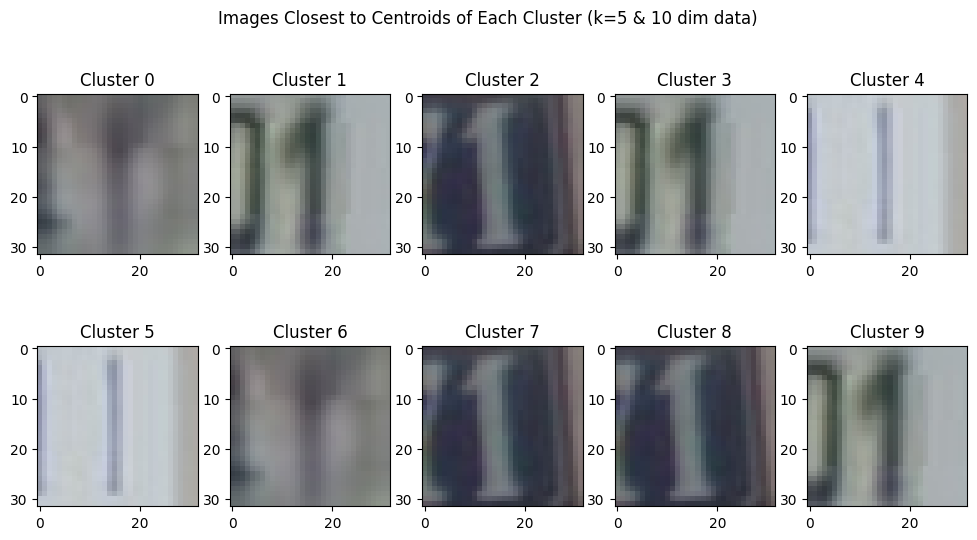

In [27]:
# Plot the images images closest to each centroid
plot_centroid_images(X,X_pca_26,kmeans_pca_26_k5,title='Images Closest to Centroids of Each Cluster (k=5 & 10 dim data)')

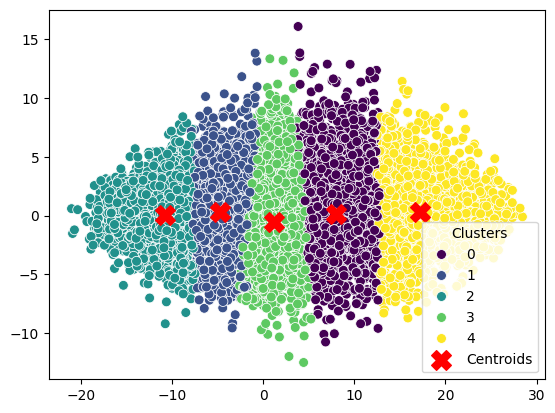

In [28]:
visualize_kmeans_clusters(X_pca_26,kmeans_pca_26_k5,title='K-means clustering on (k=5 & 10 dim data)')

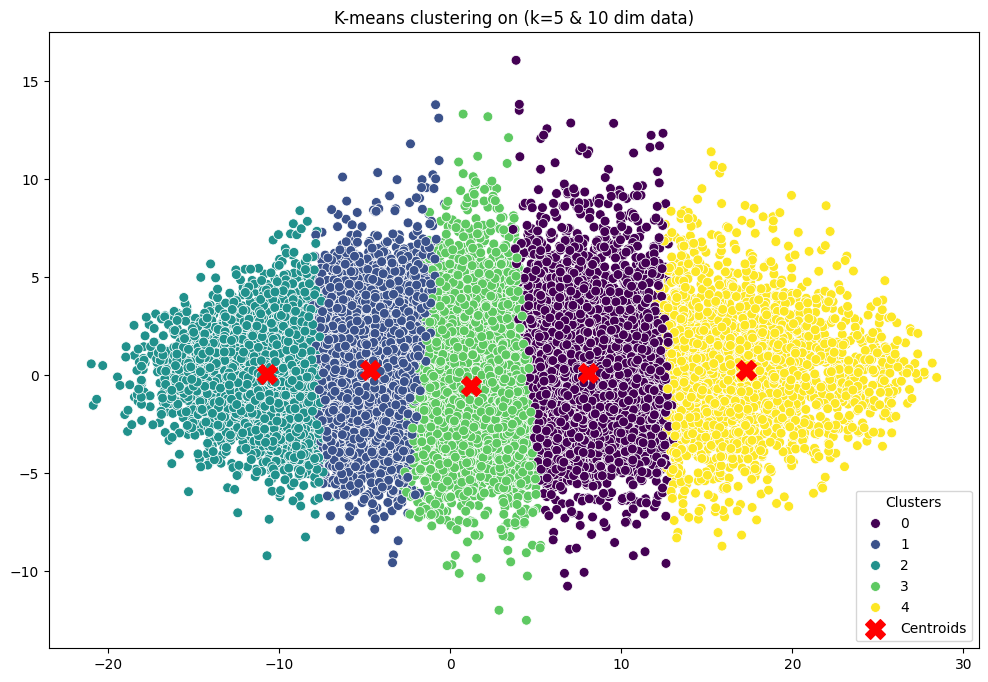

In [29]:
visualize_kmeans_clusters_pca_top2_eigen_vecotrs(X_pca_26,kmeans_pca_26_k5,title='K-means clustering on (k=5 & 10 dim data)')

In [30]:
# To find which two classes are clustered together

y_true = y.flatten()
cluster_assignments = kmeans_pca_26_k5.labels_

#  Create a DataFrame
df = pd.DataFrame({'actual_labels': y_true, 'cluster_assignments': cluster_assignments})

# Find the two most common classes for each cluster along with their frequencies
majority_classes = df.groupby('cluster_assignments')['actual_labels'].agg(lambda x: x.value_counts().index[:2].tolist())

# Print results
for cluster, (majority_class, second_majority_class) in enumerate(majority_classes):
    majority_class_freq = df[(df['cluster_assignments'] == cluster) & (df['actual_labels'] == majority_class)].shape[0]
    second_majority_class_freq = df[(df['cluster_assignments'] == cluster) & (df['actual_labels'] == second_majority_class)].shape[0]
    print(f"Cluster {cluster}: Majority Class Label = {majority_class} (Frequency = {majority_class_freq}), Second Majority Class = {second_majority_class} (Frequency = {second_majority_class_freq})")




Cluster 0: Majority Class Label = 2 (Frequency = 502), Second Majority Class = 10 (Frequency = 502)
Cluster 1: Majority Class Label = 9 (Frequency = 782), Second Majority Class = 3 (Frequency = 728)
Cluster 2: Majority Class Label = 6 (Frequency = 495), Second Majority Class = 7 (Frequency = 487)
Cluster 3: Majority Class Label = 8 (Frequency = 670), Second Majority Class = 10 (Frequency = 668)
Cluster 4: Majority Class Label = 1 (Frequency = 243), Second Majority Class = 3 (Frequency = 239)


# Observations 2(d)

### K Means clustering with k=5 on the top 26 eigen vectors

1. Sum of Squared Error = 1082550.52
2. We observe that images from different classes are clustered together as number of clusters defined is half of the actual number of classes
3. The grouping of classes within each cluster reflects the algorithm's perception of similarities among digits based on the features used for clustering. The organization suggests that digits with similar characteristics or patterns have been grouped together in each cluster.
